In [24]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import sklearn as skl 
import ast
import numpy as np
import utils

In [109]:
def build_model(shape):
  
    model = models.Sequential()
    
    model.add(Dense(128, input_dim=shape, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [3]:
genres = utils.load('audio_files\\genres.csv')
features = utils.load('audio_files\\features.csv')
echonest = utils.load('audio_files\\echonest.csv')

In [4]:
from pandas.api.types import CategoricalDtype

tracks = pd.read_csv('audio_files\\tracks.csv', index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
  tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
           ('album', 'date_created'), ('album', 'date_released'),
           ('artist', 'date_created'), ('artist', 'active_year_begin'),
           ('artist', 'active_year_end')]
for column in COLUMNS:
  tracks[column] = pd.to_datetime(tracks[column])
    
SUBSETS = ('small', 'medium', 'large')
tracks['set', 'subset'] = tracks['set', 'subset'].astype(CategoricalDtype(categories=SUBSETS, ordered=True))
COLUMNS = [('track', 'genre_top'), ('track', 'license'),
           ('album', 'type'), ('album', 'information'),('artist', 'bio')]
for column in COLUMNS:
  tracks[column] = tracks[column].astype('category')

In [26]:
np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

In [27]:
small = tracks['set', 'subset'] <= 'small'
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

In [53]:
from sklearn.preprocessing import StandardScaler

features_p = StandardScaler().fit_transform(features)

from sklearn import decomposition

PCA85 = decomposition.PCA(n_components=85)
PCA151 = decomposition.PCA(n_components=151)
PCA215 =decomposition.PCA(n_components=215)
PCA518 =decomposition.PCA(n_components=518)

pComponents85 = PCA85.fit_transform(features_p)
pComponents151 = PCA151.fit_transform(features_p)
pComponents215 = PCA215.fit_transform(features_p)
pComponents518 = PCA518.fit_transform(features_p)

print('Pour 85 facteurs : ',PCA85.explained_variance_ratio_.sum(),' de l information est expliquee\n')
print('Pour 151 facteurs : ',PCA151.explained_variance_ratio_.sum(),' de l information est expliquee\n')
print('Pour 215 facteurs : ',PCA215.explained_variance_ratio_.sum(),' de l information est expliquee\n')
print('Pour 518 facteurs : ',PCA518.explained_variance_ratio_.sum(),' de l information est expliquee\n')

Pour 85 facteurs :  0.7986096620824791  de l information est expliquee

Pour 151 facteurs :  0.8995184044042367  de l information est expliquee

Pour 215 facteurs :  0.9495558183020659  de l information est expliquee

Pour 518 facteurs :  0.9999999999999999  de l information est expliquee



In [54]:
principalDf151 = pd.DataFrame(data = pComponents151,index=tracks.index)
principalDf85 = pd.DataFrame(data = pComponents85,index=tracks.index)
principalDf215 = pd.DataFrame(data = pComponents215,index=tracks.index)
principalDf518 = pd.DataFrame(data = pComponents518,index=tracks.index)

In [55]:
X_train = principalDf518.loc[small & train]
X_val = principalDf518.loc[small & val]
X_test = principalDf518.loc[small & test]
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]

In [56]:
dict_genre = {
    'Hip-Hop': 0,
    'Pop': 1,
    'Folk': 2,
    'Rock': 3,
    'Experimental': 4,
    'International': 5,
    'Electronic': 6,
    'Instrumental': 7,
}
inv_genre_dict = {v: k for k, v in dict_genre.items()}
genre_names = [inv_genre_dict[i] for i in range(8)]

In [57]:
# X_train,y_train = skl.utils.shuffle(X_train,y_train,random_state=34)

X_train_mod=np.asarray(X_train)
X_test_mod=np.asarray(X_test)
X_val_mod = np.asarray(X_val)

# y_train_mod=np.asarray(y_train.replace(dict_genre))
# y_test_mod=np.asarray(y_test.replace(dict_genre))
# y_val_mod = np.asarray(y_val.replace(dict_genre))
le = LabelEncoder()
y_train_mod=le.fit_transform(y_train)
y_test_mod=le.fit_transform(y_test)
y_val_mod = le.fit_transform(y_val)
le.classes_

array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype=object)

In [58]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape , y_train_mod

((6400, 518), (800, 518), (6400,), (800,), array([3, 3, 6, ..., 6, 6, 3]))

In [11]:
# model = build_model(X_train.shape[1])
# es_callback = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(X_train_mod,
#                     y_train_mod,
#                     epochs=120,
#                     batch_size=128,
#                     validation_data= (X_val_mod, y_val_mod),
#                     callbacks=[es_callback])

In [12]:
# score = model.evaluate(x=X_test_mod, y=y_test_mod)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [18]:
# from sklearn.preprocessing import StandardScaler

# X_train = StandardScaler().fit_transform(X_train)

In [19]:
# from sklearn import decomposition

# PCA85 = decomposition.PCA(n_components=85)
# PCA151 = decomposition.PCA(n_components=151)
# PCA215 =decomposition.PCA(n_components=215)
# PCA518 =decomposition.PCA(n_components=518)

In [22]:
# pComponents85_tr = PCA85.fit_transform(X_train)
# pComponents151_tr = PCA151.fit_transform(X_train)
# pComponents215_tr = PCA215.fit_transform(X_train)
# pComponents518_tr = PCA518.fit_transform(X_train)

In [51]:
# print('Pour 85 facteurs : ',PCA85.explained_variance_ratio_.sum(),' de l information est expliquee\n')
# print('Pour 151 facteurs : ',PCA151.explained_variance_ratio_.sum(),' de l information est expliquee\n')
# print('Pour 215 facteurs : ',PCA215.explained_variance_ratio_.sum(),' de l information est expliquee\n')
# print('Pour 518 facteurs : ',PCA518.explained_variance_ratio_.sum(),' de l information est expliquee\n')

In [52]:
# principalDf151 = pd.DataFrame(data = pComponents151)
# principalDf85 = pd.DataFrame(data = pComponents85)
# principalDf215 = pd.DataFrame(data = pComponents215)

# principalDf85.shape,principalDf151.shape,principalDf215.shape,pComponents518_v.shape

((106574, 85), (106574, 151), (106574, 215), (800, 518))

In [110]:
tb_hist = TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)

model = build_model(X_train.shape[1])
es_callback = EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(X_train_mod,
                    y_train_mod,
                    epochs=120,
                    batch_size=128,
                    shuffle=True,
                    validation_data= (X_val_mod, y_val_mod),
                    callbacks=[es_callback])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               66432     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 520       
Total params: 75,208
Trainable params: 75,208
Non-trainable params: 0
_________________________________________________________________
Train on 6400 samples, validate on 800 samples
Epoch 1/120
6400/6400 [==============================] - 1s 129us/sa

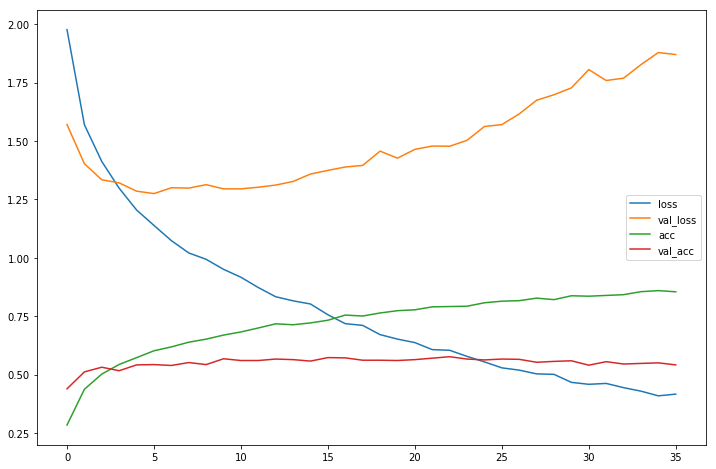

800/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [111]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

score = model.evaluate(x=X_test_mod, y=y_test_mod)

In [112]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.3508206272125243
Test accuracy: 0.4525
